In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
from arch import arch_model
#from arch.univariate import GARCH, EGARCH, ConstantMean, Normal
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
# ARCH EFFECTS TESTING

# We use Bitcoin data, which is highly volatile, as a running example.
ticker = 'BTC-USD'
print("Downloading Bitcoin Data...")
btc = yf.download(ticker, start='2020-01-01', end='2026-01-01', progress=False, auto_adjust=True)['Close']
returns =  np.log(btc / btc.shift(1)).dropna() * 100 # log return

print(f"Sample period: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Number of observations: {len(returns)}")

# We assume the return series has a constant mean, so the following tests on residuals can be applied directly to the raw return series. 
# Ljung-Box test on returns and squared returns
from statsmodels.stats.diagnostic import acorr_ljungbox
print("\nLjung-Box Test (10 lags)...")
lb_returns = acorr_ljungbox(returns, lags=[10], return_df=True) # lags=[10], only the tests for the lags in the list are reported; lags=10, test results for all smallers lags are reported
lb_squared = acorr_ljungbox(returns**2, lags=[10], return_df=True)
print(f"- on returns p-value: {lb_returns['lb_pvalue'].iloc[0]:.4f}")
print(f"- on squared returns p-value: {lb_squared['lb_pvalue'].iloc[0]:.4e}")
if lb_squared['lb_pvalue'].iloc[0] < 0.05:
    print("=> Low p-value on squared returns indicates ARCH effects")

# Lagrange multiplier test
from statsmodels.stats.diagnostic import het_arch
print("\nLagrange Multiplier Test (5 lags)...")
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(returns, nlags=5) # het_arch automatically squares the series internally to perform the LM test
print(f"LM statistic: {lm_stat:.4f}, p-value: {lm_pvalue:.4e}")
print(f"F-statistic: {f_stat:.4f}, p-value: {f_pvalue:.4e}")
if (lm_pvalue < 0.05) and (f_pvalue < 0.05):
    print("=> Strong evidence of ARCH effects (reject homoscedasticity)")


Sample period: 2020-01-02 to 2025-12-31
Number of observations: 2191

Ljung-Box Test (10 lags)...
- on returns p-value: 0.0006
- on squared returns p-value: 1.7014e-07
=> Low p-value on squared returns indicates ARCH effects

Lagrange Multiplier Test (5 lags)...
LM statistic: 17.7449, p-value: 3.2837e-03
F-statistic: 3.5682, p-value: 3.2342e-03
=> Strong evidence of ARCH effects (reject homoscedasticity)


In [3]:
# ASYMMETRIC VOLATILITY (LEVERAGE EFFECT)

# The leverage effect says that negative returns increase volatility more than positive returns 
# We test this by correlating returns with future volatility changes

window = 21
annualization_factor = np.sqrt(252)
# When calculating realized variance (sum of squared returns), returns are typically not demeaned.
# The calculation here uses standard deviation for simplicity, which does demean by default.
ann_rolling_realized_vol = returns.rolling(window=window).std() * annualization_factor # rolling realized volatility

# Separate positive and negative return days
positive_days = returns > 0
negative_days = returns < 0

# Average volatility following positive vs negative returns
vol_on_positive_days = ann_rolling_realized_vol[positive_days].mean()
vol_on_negative_days = ann_rolling_realized_vol[negative_days].mean()

print(f"Average rolling realized volatility ({window}-day, annualized)...")
print(f"- on positive return days: {vol_on_positive_days.iloc[0]:.4f}%")
print(f"- on negative return days: {vol_on_negative_days.iloc[0]:.4f}%")

# Correlation between returns and future volatility changes
vol_change = ann_rolling_realized_vol.diff()
correlation = returns[ticker].corr(vol_change.shift(-1)[ticker])
print(f"\nCorrelation between today's return & next day volatility change: {correlation:.4f}")
if correlation < 0:
    print("=> Negative correlation confirms leverage effect")

Average rolling realized volatility (21-day, annualized)...
- on positive return days: 46.7582%
- on negative return days: 46.0629%

Correlation between today's return & next day volatility change: -0.0591
=> Negative correlation confirms leverage effect


In [4]:
# FIT GARCH(1,1)

# mean eauation: r_t = \mu + a_t
# a_t = \sigma_t \epsilon_t, 
# \sigma_t^2 = \omega + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2

garch = arch_model(
    returns,
    vol="GARCH",
    p=1, q=1,
    mean="Constant", # constant mean
    dist="Normal"  # distribution for the standardized residual \epsilon_t = a_t / \sigma_t
)

garch_fit = garch.fit(disp="off")
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                BTC-USD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5541.04
Distribution:                  Normal   AIC:                           11090.1
Method:            Maximum Likelihood   BIC:                           11112.9
                                        No. Observations:                 2191
Date:                Tue, Jan 20 2026   Df Residuals:                     2190
Time:                        18:07:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1653  6.619e-02      2.497  1.253e-02 [3.554e-0

In [5]:
# FIT EGARCH(1,1)

# \ln(\sigma_t^2) = \omega + \alpha_1  |a_{t-1}|/\sigma_{t-1} + \gamma_1 a_{t-1}/\sigma_{t-1} + \beta_1 \ln(\sigma_{t-1}^2)
# \gamma < 0 would signify the leverage effect

egarch = arch_model(
    returns,
    vol="EGARCH",
    p=1, o=1, q=1,
    dist="Normal"
)

egarch_fit = egarch.fit(disp="off")
print(egarch_fit.summary())

e_gamma = egarch_fit.params['gamma[1]']
e_gamma_p_value = egarch_fit.pvalues['gamma[1]']
print(f"\nLeverage effect coefficient (gamma[1]): {e_gamma:.4f}")
print(f"p-value: {e_gamma_p_value:.4f}")

if e_gamma_p_value < 0.05:
    print(f"=> Significant leverage effect (p < 0.05)")
else:
    print(f"=> No significant leverage effect")


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                BTC-USD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5531.28
Distribution:                  Normal   AIC:                           11072.6
Method:            Maximum Likelihood   BIC:                           11101.0
                                        No. Observations:                 2191
Date:                Tue, Jan 20 2026   Df Residuals:                     2190
Time:                        18:07:44   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1200  1.006e-03    119.287      0.000 [  0.118,  0.12

In [6]:
# FIT GJR-GARCH(1,1)

# \sigma_t^2 = \omega + \alpha_1 a_{t-1}^2 + \gamma_1 I_{t-1} a_{t-1}^2 + \beta_1 \sigma_{t-1}^2
# I_{t-1} is an indicator for negative a_{t-1}
# \gamma > 0 indicates that negative shocks raise volatility more

gjr = arch_model(
    returns,
    vol="GARCH",
    p=1, o=1, q=1,
    dist="Normal"
)

gjr_fit = gjr.fit(disp="off")
print(gjr_fit.summary())

gjr_gamma = gjr_fit.params['gamma[1]']
gjr_gamma_pval = gjr_fit.pvalues['gamma[1]']
print(f"\nLeverage effect coefficient (gamma[1]): {gjr_gamma:.4f}")
print(f"p-value: {gjr_gamma_pval:.4f}")

if gjr_gamma_pval < 0.05:
    print(f"=> Significant leverage effect (p < 0.05)")
else:
    print(f"=> No significant leverage effect")

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                BTC-USD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -5527.65
Distribution:                  Normal   AIC:                           11065.3
Method:            Maximum Likelihood   BIC:                           11093.8
                                        No. Observations:                 2191
Date:                Tue, Jan 20 2026   Df Residuals:                     2190
Time:                        18:07:44   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1074  5.810e-02      1.848  6.465e-02 [-6.52

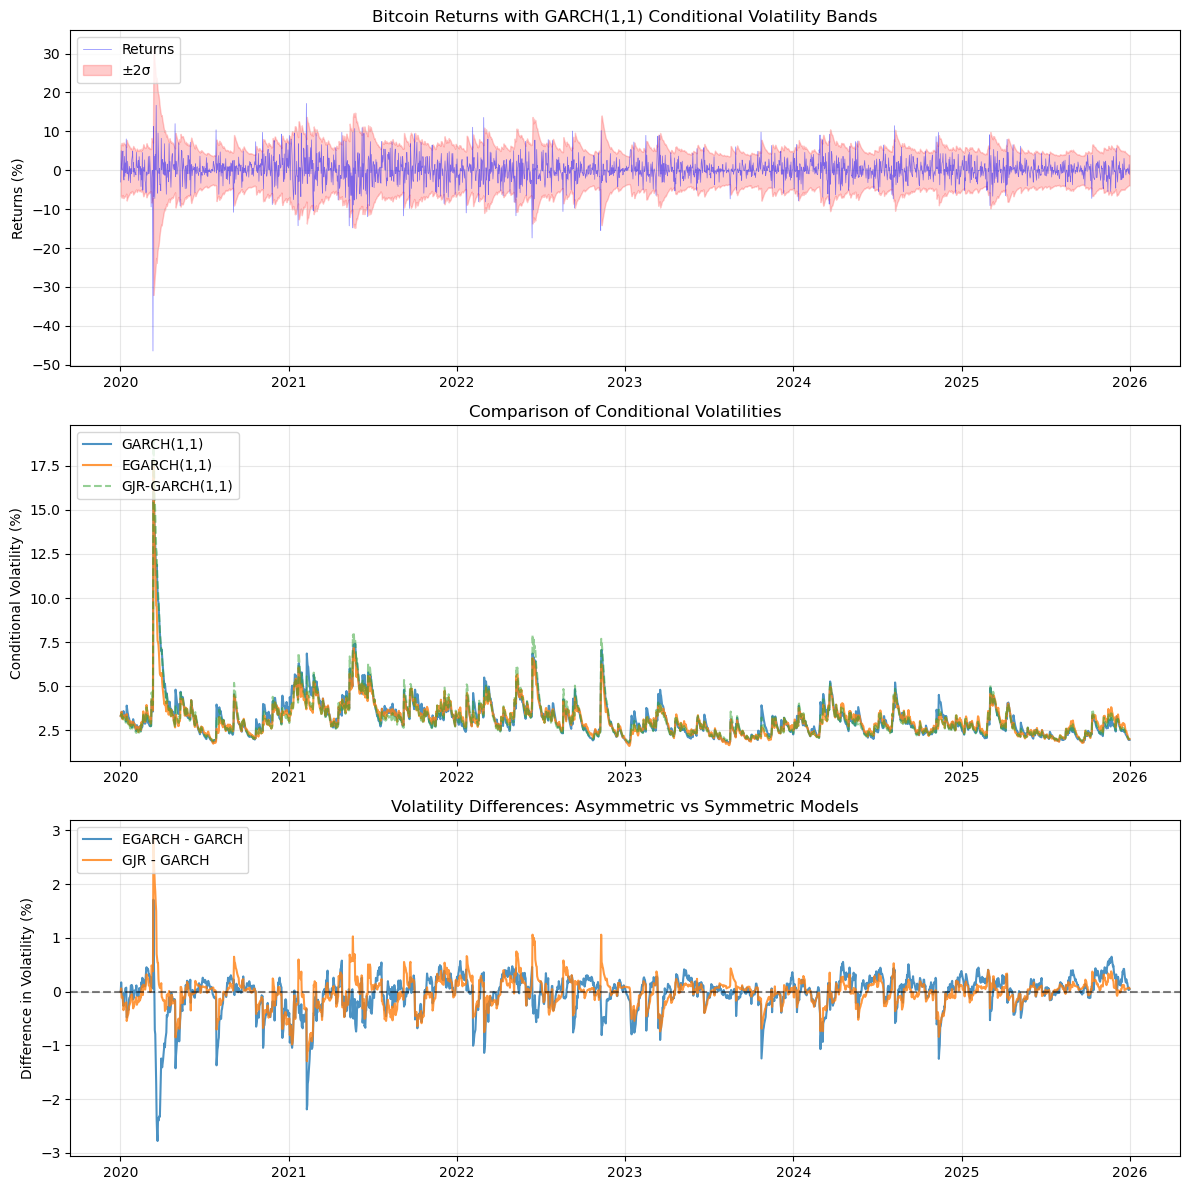

In [7]:
# Conditional volatility: the expected volatility at time t given all information available up to time t-1
garch_vol = garch_fit.conditional_volatility
egarch_vol = egarch_fit.conditional_volatility
gjr_vol = gjr_fit.conditional_volatility

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
# Plot 1: Returns with GARCH conditional volatility
axes[0].plot(returns.index, returns, linewidth=0.5, alpha=0.5, label='Returns', color='blue')
axes[0].fill_between(returns.index, -2*garch_vol, 2*garch_vol, alpha=0.2, color='red', label='±2σ')
axes[0].set_title('Bitcoin Returns with GARCH(1,1) Conditional Volatility Bands')
axes[0].set_ylabel('Returns (%)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Comparison of conditional volatilities
axes[1].plot(garch_vol.index, garch_vol, label='GARCH(1,1)', alpha=0.8)
axes[1].plot(egarch_vol.index, egarch_vol, label='EGARCH(1,1)', alpha=0.8)
axes[1].plot(gjr_vol.index, gjr_vol, label='GJR-GARCH(1,1)', linestyle='--', alpha=0.5)
axes[1].set_title('Comparison of Conditional Volatilities')
axes[1].set_ylabel('Conditional Volatility (%)')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Plot 3: Difference between models (highlighting asymmetry)
axes[2].plot((egarch_vol - garch_vol).index, egarch_vol - garch_vol, 
            label='EGARCH - GARCH', alpha=0.8)
axes[2].plot((gjr_vol - garch_vol).index, gjr_vol - garch_vol, 
            label='GJR - GARCH', alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('Volatility Differences: Asymmetric vs Symmetric Models')
axes[2].set_ylabel('Difference in Volatility (%)')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# RESIDUAL ANALYSIS

# If GARCH correctly captures volatility clustering, residuals should have no ARCH effects
std_resids = garch_fit.std_resid

print("Statistics of GARCH Residuals:")
print(std_resids.describe())

# Test for normality
jb_resids = stats.jarque_bera(std_resids.dropna())
print(f"\nTest for Normality...")
print(f"- Jarque-Bera: {jb_resids[0]:.2f}, p-value: {jb_resids[1]:.4e}")
print(f"- Skewness: {stats.skew(std_resids.dropna()):.4f}")
print(f"- Kurtosis: {stats.kurtosis(std_resids.dropna()):.4f}")

# Test for remaining ARCH effects
print(f"\nTest for Remaining ARCH Effects...")
# Ljung-Box test
lb_resids_sq = acorr_ljungbox(std_resids.dropna()**2, lags=[10], return_df=True)
print(f"- Ljung-Box test statistic: {lb_resids_sq['lb_stat'].iloc[0]:.4f}, p-value: {lb_resids_sq['lb_pvalue'].iloc[0]:.4e}")

arch_resids = het_arch(std_resids.dropna(), nlags=5)
print(f"- ARCH-LM test statistic: {arch_resids[0]:.4f}, p-value: {arch_resids[1]:.4e}")

if (lb_resids_sq['lb_pvalue'].iloc[0] > 0.05) and (arch_resids[1] > 0.05):
    print("=> High p-value indicates GARCH successfully removed ARCH effects")

Statistics of GARCH Residuals:
count    2191.000000
mean       -0.020225
std         1.000092
min       -13.082208
25%        -0.474340
50%        -0.041055
75%         0.440967
max         5.098116
Name: std_resid, dtype: float64

Test for Normality...
- Jarque-Bera: 22622.32, p-value: 0.0000e+00
- Skewness: -0.9960
- Kurtosis: 15.6152

Test for Remaining ARCH Effects...
- Ljung-Box test statistic: 6.8708, p-value: 7.3759e-01
- ARCH-LM test statistic: 5.6412, p-value: 3.4272e-01
=> High p-value indicates GARCH successfully removed ARCH effects


In [9]:
# VOLATILITY FORECASTING

# Rolling window forecast
window = 1800
forecasts_garch = []
forecasts_egarch = []
forecasts_gjr = []
actuals = []

for i in range(window, len(returns) - 1):
    train_window = returns.iloc[i-window:i]
    actual = returns.iloc[i+1]

    try:
        m_garch = arch_model(train_window, vol='GARCH', p=1, q=1).fit(disp='off', show_warning=False)
        m_egarch = arch_model(train_window, vol='EGARCH', p=1, o=1, q=1).fit(disp='off', show_warning=False)
        m_gjr = arch_model(train_window, vol='GARCH', p=1, o=1, q=1).fit(disp='off', show_warning=False)
        
        # 1-step ahead forecast
        f_garch = m_garch.forecast(horizon=1)
        f_egarch = m_egarch.forecast(horizon=1)
        f_gjr = m_gjr.forecast(horizon=1)
        
        forecasts_garch.append(np.sqrt(f_garch.variance.values[-1, 0]))
        forecasts_egarch.append(np.sqrt(f_egarch.variance.values[-1, 0]))
        forecasts_gjr.append(np.sqrt(f_gjr.variance.values[-1, 0]))
        actuals.append(np.abs(actual[ticker]))
    except:
        continue

forecasts_garch = np.array(forecasts_garch)
forecasts_egarch = np.array(forecasts_egarch)
forecasts_gjr = np.array(forecasts_gjr)
actuals = np.array(actuals)

# Calculate MSE for rolling forecasts
mse_roll_garch = np.mean((forecasts_garch - actuals)**2)
mse_roll_egarch = np.mean((forecasts_egarch - actuals)**2)
mse_roll_gjr = np.mean((forecasts_gjr - actuals)**2)

print(f"Mean Squared Error (Rolling Window)...")
print(f"- GARCH(1,1): {mse_roll_garch:.6f}")
print(f"- EGARCH(1,1): {mse_roll_egarch:.6f}")
print(f"- GJR-GARCH(1,1): {mse_roll_gjr:.6f}")

Mean Squared Error (Rolling Window)...
- GARCH(1,1): 3.179891
- EGARCH(1,1): 3.382173
- GJR-GARCH(1,1): 3.243302


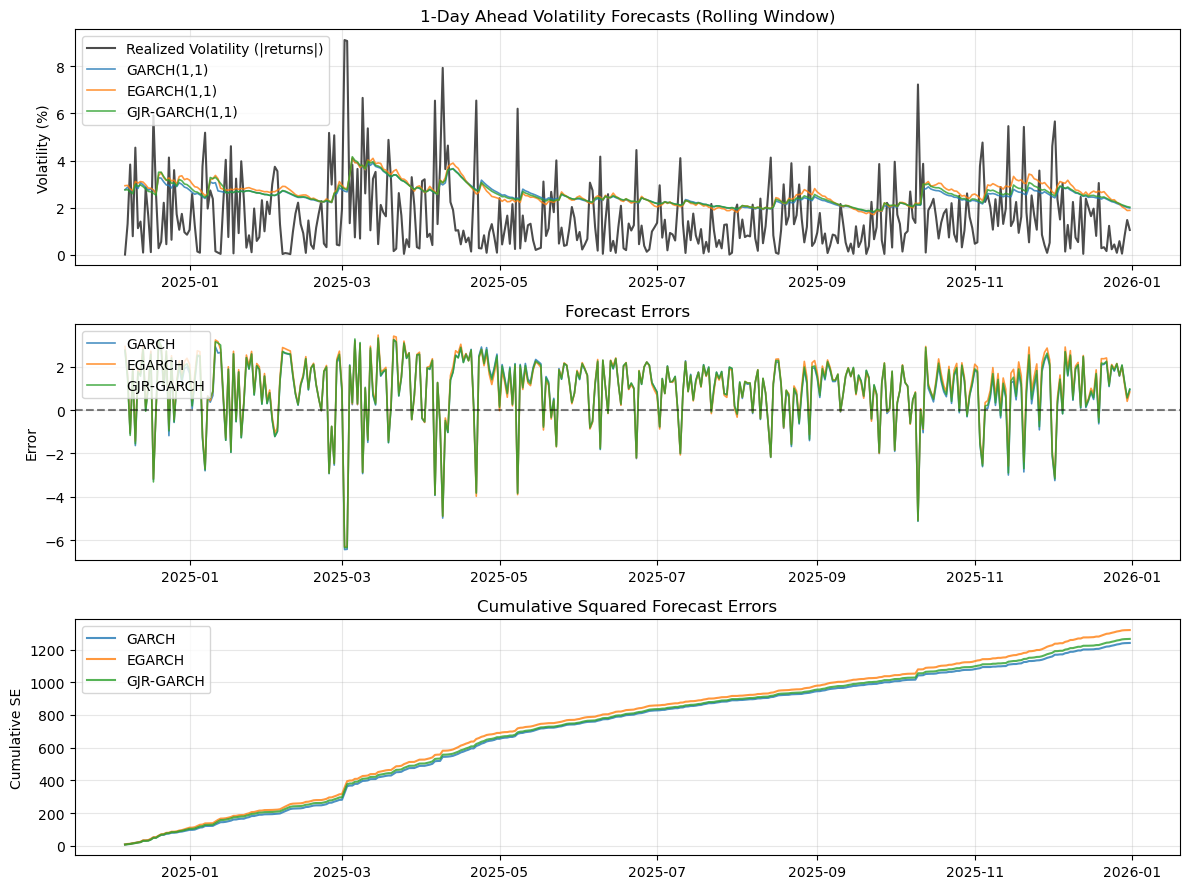

In [10]:
# Visualizations
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

dates = returns.index[window+1:window+1+len(actuals)]

# Plot 1: Actual vs forecasted volatility
axes[0].plot(dates, actuals, label='Realized Volatility (|returns|)', 
                linewidth=1.5, alpha=0.7, color='black')
axes[0].plot(dates, forecasts_garch, label='GARCH(1,1)', linewidth=1.2, alpha=0.8)
axes[0].plot(dates, forecasts_egarch, label='EGARCH(1,1)', linewidth=1.2, alpha=0.8)
axes[0].plot(dates, forecasts_gjr, label='GJR-GARCH(1,1)', linewidth=1.2, alpha=0.8)
axes[0].set_title('1-Day Ahead Volatility Forecasts (Rolling Window)')
axes[0].set_ylabel('Volatility (%)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Forecast errors
axes[1].plot(dates, forecasts_garch - actuals, label='GARCH', linewidth=1.2, alpha=0.8)
axes[1].plot(dates, forecasts_egarch - actuals, label='EGARCH', linewidth=1.2, alpha=0.8)
axes[1].plot(dates, forecasts_gjr - actuals, label='GJR-GARCH', linewidth=1.2, alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Forecast Errors')
axes[1].set_ylabel('Error')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Plot 3: Cumulative squared errors
cum_se_garch = np.cumsum((forecasts_garch - actuals)**2)
cum_se_egarch = np.cumsum((forecasts_egarch - actuals)**2)
cum_se_gjr = np.cumsum((forecasts_gjr - actuals)**2)

axes[2].plot(dates, cum_se_garch, label='GARCH', linewidth=1.5, alpha=0.8)
axes[2].plot(dates, cum_se_egarch, label='EGARCH', linewidth=1.5, alpha=0.8)
axes[2].plot(dates, cum_se_gjr, label='GJR-GARCH', linewidth=1.5, alpha=0.8)
axes[2].set_title('Cumulative Squared Forecast Errors')
axes[2].set_ylabel('Cumulative SE')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# VALUE AT RISK (VaR) ESTIMATION

# We use GARCH(1,1) conditional volatility to estimate VaR dynamically
cond_vol = garch_fit.conditional_volatility
std_resids = garch_fit.std_resid

alpha = 0.99 # confidence level

# Dynamic VaR (Normal)
z_score_normal = stats.norm.ppf(1 - alpha)
var_normal = -z_score_normal * cond_vol + garch_fit.params["mu"]

# Dynamic VaR (Empirical)
z_score_empirical = np.percentile(std_resids.dropna(), (1 - alpha) * 100)
var_empirical = -z_score_empirical * cond_vol + garch_fit.params["mu"]

# Historical VaR (using rolling window)
window = 251
var_historical = -returns.rolling(window=window).quantile(1 - alpha)

# Count violations
violations_normal = (returns[ticker] < -var_normal).sum()
violations_empirical = (returns[ticker] < -var_empirical).sum()
violations_historical = (returns[ticker] < -var_historical[ticker]).sum()

expected_violations = len(returns) * (1 - alpha)

print(f"\n# of Violations (actual losses exceeding the 1-day {alpha*100:.0f}% VaR)...")
print(f"- Dynamic VaR (Normal): {violations_normal} ({100*violations_normal/len(returns):.2f}%)")
print(f"- Dynamic VaR (Empirical): {violations_empirical} ({100*violations_empirical/len(returns):.2f}%)")
print(f"- Historical VaR: {violations_historical} ({100*violations_historical/len(returns[window:]):.2f}%)")
print(f"- Expected violations: {expected_violations:.1f} ({100*(1-alpha):.2f}%)")

# Kupiec test to check if the frequency of violations matches the specified confidence level 
from scipy.stats import chi2
def kupiec_test(T,x,alpha): 
    p = 1 - alpha
    LR = -2 * np.log(((1-p)**(T-x) * p**x) /
                 ((1-x/T)**(T-x) * (x/T)**x))
    kupiec_p_value = 1 - chi2.cdf(LR, 1)
    return kupiec_p_value

T = len(returns)

print("\nKupiec test...")
print(f"- Dynamic VaR (Normal) p-value: {kupiec_test(T,violations_normal,alpha):.4f}")
print(f"- Dynamic VaR (Empirical) p-value: {kupiec_test(T,violations_empirical,alpha):.4f}")
print("p-value > 0.05 => VaR model is adequate")


# of Violations (actual losses exceeding the 1-day 99% VaR)...
- Dynamic VaR (Normal): 31 (1.41%)
- Dynamic VaR (Empirical): 18 (0.82%)
- Historical VaR: 18 (0.93%)
- Expected violations: 21.9 (1.00%)

Kupiec test...
- Dynamic VaR (Normal) p-value: 0.0662
- Dynamic VaR (Empirical) p-value: 0.3863
p-value > 0.05 => VaR model is adequate
